# Metodologia de Classificação Climática de Cidades  
**Autor:** John Costa

**Fontes dos Dados:**  
- [Instituto Português do Mar e da Atmosfera (IPMA)](https://www.ipma.pt/)
- [World Weather Online](https://www.worldweatheronline.com/)
- [Open-Meteo](https://open-meteo.com/)
- [Shape Portugal - Natural Earth](https://www.naturalearthdata.com/)

---

## Objetivo

Este documento explica, de forma simples e transparente, como foi realizada a classificação do clima das cidades de Portugal (e exemplos do Brasil), mostrando a lógica utilizada no cálculo do score climático, os critérios para extremos, a metodologia dos índices e as influências dos fatores naturais e humanos no clima. Exemplos reais ilustram cada etapa.

---

## 1. **Elementos e Fatores Climáticos**

### **Elementos do Clima**  
São as características do ambiente que sentimos ou medimos no dia a dia:

- **Temperatura**: grau de calor do ar.
- **Umidade**: quantidade de vapor d’água presente no ar.
- **Pressão atmosférica**: força do ar sobre a superfície.
- **Precipitação**: chuva, neve ou granizo.
- **Ventos**: movimentação do ar.
- **Radiação solar**: energia recebida do Sol.

### **Fatores Climáticos**  
São aspectos que modificam ou influenciam os elementos:

| Fator                | Como influencia a temperatura e outros elementos                       | Exemplo prático                         |
|----------------------|-----------------------------------------------------------------------|-----------------------------------------|
| **Latitude**         | Próximo ao Equador = mais quente; longe = mais frio                   | Algarve mais quente que Porto           |
| **Altitude/Relevo**  | Locais altos = mais frio                                              | Serra da Estrela com neve               |
| **Maritimidade**     | Próximo ao mar = menos variação térmica                               | Lisboa com invernos mais amenos         |
| **Continentalidade** | Interior = maior variação entre verão e inverno                       | Interior do Alentejo mais extremo       |
| **Correntes Marítimas** | Correntes frias/quentes afetam temperatura do litoral               | Corrente do Golfo suaviza litoral oeste |
| **Uso/Ocupação do Solo** | Cidades são mais quentes (ilhas de calor), menos vegetação         | Centro de Lisboa mais quente            |

---

## 2. **Aparelhos de Medição Climática**

- **Termômetro**: mede temperatura do ar.
- **Pluviómetro**: mede a quantidade de chuva (mm).
- **Higrômetro**: mede a umidade relativa do ar.
- **Barômetro**: mede a pressão atmosférica.
- **Anemômetro**: mede a velocidade dos ventos.
- **Heliógrafo**: mede horas de sol.
- **Biruta**: indica a direção do vento.

As medições são realizadas em estações meteorológicas espalhadas nas cidades.

---

## 3. **Metodologia de Classificação**

### **a) Identificação de Eventos Extremos**

Um dia é considerado extremo se atender ao menos um dos critérios abaixo:
- **Calor extremo**: máxima > 35°C ou Heat Index > 40°C
- **Frio extremo**: mínima < -3°C ou Wind Chill < -5°C
- **Chuva extrema**: precipitação diária acima de 30 mm *(ajustado para a média portuguesa)*
- **Neve**: qualquer valor positivo em Portugal continental
- **UV extremo**: índice ≥ 8

### **b) Cálculo do "Clima Típico"**

- Remove dias extremos do cálculo das médias anuais de cada variável.
- Calcula as médias dos elementos climáticos principais: máxima, mínima, sensação térmica, umidade, chuva, sol e UV.

### **c) Score de Conforto Climático**

#### **Ponderação**
O score parte de 100 e utiliza média dos dias "típicos" (sem extremos):

- Temperatura máxima ideal (22 a 28°C): 60%
- Umidade (30-80%): 15%
- Sol (≥ 5h/dia): 15%
- Precipitação (≤ 20mm/dia): 10%

*Se a máxima anual for muito baixa (≤ 21°C), a pontuação máxima na temperatura cai, refletindo clima considerado frio para conforto.*

#### **Penalização por Extremos**
- Calor extremo: -0,3 ponto por dia
- Frio extremo: -0,4 ponto por dia
- Chuva extrema: -0,2 ponto por dia
- Penalização máxima limitada a 20 pontos

### **d) Classificação Final**

| Score         | Classificação |
|---------------|--------------|
| ≥ 80          | Excelente    |
| 70 a 79,99    | Muito Bom    |
| 60 a 69,99    | Bom          |
| 50 a 59,99    | Aceitável    |
| < 50          | Marginal     |

---

## 4. **Exemplo de Aplicação**

### **Lisboa**
- Máxima média: 25,6°C
- Mínima média: 15,8°C
- Umidade: 69%
- Chuva: 1,9 mm/dia
- Dias extremos: 2 de calor, 0 de frio, 2 de chuva
- **Score:** 88,4 → **Classificação: Excelente**

### **Porto**
- Máxima média: 22,8°C
- Mínima média: 12,5°C
- Umidade: 74%
- Chuva: 2,8 mm/dia
- Dias extremos: 0 de calor, 0 de frio, 3 de chuva
- **Score:** 81,2 → **Classificação: Excelente**

### **São Paulo (Brasil)**
- Máxima média: 28,3°C
- Mínima média: 16,9°C
- Umidade: 64%
- Chuva: 2,0 mm/dia
- Dias extremos: 9 de calor, 0 de frio, 23 de chuva
- **Score:** 62,1 → **Classificação: Bom**

---

## 5. **Visualização no Mapa**

Cada cidade foi plotada em um mapa de Portugal, colorida conforme a classificação:
- **Azul**: Excelente / Muito Bom
- **Verde**: Bom
- **Amarelo**: Aceitável
- **Vermelho**: Marginal

<sub>*Sugestão: Utilize bibliotecas como `geopandas` e `matplotlib` para criar o mapa. Veja exemplo de código na documentação técnica.*</sub>

---

## 6. **Considerações**

- Os dados usados são médias diárias, podendo haver limitações para eventos de chuva intensa em curto período.
- Os extremos são baseados em referências de saúde pública e médias portuguesas.
- A metodologia busca um equilíbrio entre conforto humano e variabilidade natural do clima, facilitando comparação entre cidades.

---

## 7. **Referências**

- IPMA - Instituto Português do Mar e da Atmosfera ([site](https://www.ipma.pt/))
- World Weather Online ([site](https://www.worldweatheronline.com/))
- Mieczkowski, Z. (1985). The Tourism Climate Index: A Method of Evaluating World Climates for Tourism.
- Artigos de Meteorologia, sites oficiais de institutos e literatura de conforto climático.


In [2]:
import pandas as pd
import numpy as np
import os

# === FUNÇÕES DE DETECÇÃO DE EVENTOS EXTREMOS ===
def is_hot_extreme(row):
    """
    Identifica evento de calor extremo:
    - Temperatura máxima > 35°C OU Heat Index > 40°C.
    """
    return row['maxtempC'] > 35 or row['HeatIndexC'] > 40

def is_cold_extreme(row):
    """
    Identifica evento de frio extremo:
    - Temperatura mínima < -3°C OU Wind Chill < -5°C.
    """
    return row['mintempC'] < -3 or row['WindChillC'] < -5

def is_rain_extreme(row):
    """
    Identifica chuva extrema:
    - Precipitação diária > 35 mm.
    """
    return row['precipMM'] > 35

def is_snow_extreme(row):
    """
    Identifica presença de neve:
    - Qualquer valor positivo já é evento extremo em Portugal continental.
    """
    return row['totalSnow_cm'] > 0

def is_uv_extreme(row):
    """
    Identifica radiação UV extrema:
    - Índice UV >= 8 (OMS: muito alto).
    """
    return row['uvIndex'] >= 8

# === FUNÇÕES AUXILIARES ===
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Inverno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verão'
    else:
        return 'Outono'

def classify_city_index(score):
    if score >= 80:
        return 'Excelente'
    elif score >= 70:
        return 'Muito Bom'
    elif score >= 60:
        return 'Bom'
    elif score >= 50:
        return 'Aceitável'
    else:
        return 'Marginal'

# === CÁLCULO DO TCI - Tourism Climate Index ===
def compute_tci_monthly(df):
    df['month'] = df['date_time'].dt.month
    tci_list = []
    for (year, month), dfg in df.groupby([df['date_time'].dt.year, 'month']):
        # ---- CID: conforto diário (temp média)
        tmean = dfg['tempC'].mean()
        rhmean = dfg['humidity'].mean()
        if 20 <= tmean <= 27:
            cid = 10
        elif 16 <= tmean < 20 or 27 < tmean <= 30:
            cid = 7
        elif 13 <= tmean < 16 or 30 < tmean <= 33:
            cid = 5
        elif 10 <= tmean < 13 or 33 < tmean <= 36:
            cid = 3
        else:
            cid = 0
        if rhmean > 90 or rhmean < 30:
            cid -= 1

        # ---- CIA: conforto amplitude diária (temp máxima)
        tmax = dfg['maxtempC'].mean()
        rhmax = dfg['humidity'].mean()
        if 20 <= tmax <= 27:
            cia = 10
        elif 16 <= tmax < 20 or 27 < tmax <= 30:
            cia = 7
        elif 13 <= tmax < 16 or 30 < tmax <= 33:
            cia = 5
        elif 10 <= tmax < 13 or 33 < tmax <= 36:
            cia = 3
        else:
            cia = 0
        if rhmax > 90 or rhmax < 30:
            cia -= 1

        # ---- P: índice de precipitação do mês
        p = dfg['precipMM'].sum()
        if p <= 30:
            pi = 10
        elif p <= 60:
            pi = 7
        elif p <= 90:
            pi = 5
        elif p <= 120:
            pi = 3
        else:
            pi = 0

        # ---- S: insolação média diária
        s = dfg['sunHour'].mean()
        if s >= 9:
            si = 10
        elif s >= 7:
            si = 7
        elif s >= 5:
            si = 5
        elif s >= 3:
            si = 3
        else:
            si = 0

        # ---- W: vento médio no mês
        w = dfg['windspeedKmph'].mean()
        if w < 15:
            wi = 10
        elif w < 25:
            wi = 7
        elif w < 35:
            wi = 5
        elif w < 45:
            wi = 3
        else:
            wi = 0

        tci = 2*cid + 2*cia + 0.5*pi + 0.5*si + wi
        tci = max(0, min(100, tci))
        tci_list.append({'ano': year, 'mes': month, 'tci': tci})

    tci_df = pd.DataFrame(tci_list)
    tci_annual = tci_df['tci'].mean() if not tci_df.empty else np.nan
    return tci_annual, tci_df

# === PROCESSAMENTO DE UMA CIDADE ===
def process_city(df_city):
    # Identifica dias extremos
    mask_extreme = (
        df_city.apply(is_hot_extreme, axis=1) |
        df_city.apply(is_cold_extreme, axis=1) |
        df_city.apply(is_rain_extreme, axis=1) |
        df_city.apply(is_snow_extreme, axis=1)
    )
    # Contagem dos eventos extremos (usado tanto para penalização quanto para relatório)
    eventos = {
        'calor_extremo': df_city.apply(is_hot_extreme, axis=1).sum(),
        'frio_extremo': df_city.apply(is_cold_extreme, axis=1).sum(),
        'chuva_extrema': df_city.apply(is_rain_extreme, axis=1).sum(),
        'neve': df_city.apply(is_snow_extreme, axis=1).sum(),
        'uv_extremo': df_city.apply(is_uv_extreme, axis=1).sum(),
    }
    # Remove extremos para cálculo do "clima típico"
    df_no_extremes = df_city[~mask_extreme]
    medias = df_no_extremes[['maxtempC','mintempC','FeelsLikeC','humidity','precipMM','sunHour','uvIndex']].mean().to_dict()

    # Score de conforto customizado (simples, ponderado)
    
    ideal_temp = df_no_extremes['maxtempC'].between(20, 28).mean()
    moderate_temp = ((df_no_extremes['maxtempC'] > 18) & (df_no_extremes['maxtempC'] < 32)).mean()
    
    # Nova ponderação (ajuste conforme achar melhor)
    comfort_temp = 0.7 * ideal_temp + 0.3 * moderate_temp

    #comfort_temp = (df_no_extremes['FeelsLikeC'].between(8,29)).mean()
    comfort_hum = (df_no_extremes['humidity'].between(30,80)).mean()
    comfort_sun = (df_no_extremes['sunHour'] >= 5).mean()
    comfort_precip = (df_no_extremes['precipMM'] <= 20).mean()

    # === AJUSTE: penalização sempre baseada nos extremos do ano todo ===
    hot_days = eventos['calor_extremo']
    cold_days = eventos['frio_extremo']
    rainy_days = eventos['chuva_extrema']

    # Score base
    score = 100 * (0.6*comfort_temp + 0.15*comfort_hum + 0.15*comfort_sun + 0.1*comfort_precip)
    penalizacao = 0.3*hot_days + 0.2*rainy_days + 0.4*cold_days
    penalizacao = min(penalizacao, 20)
    score -= penalizacao
    score = max(score, 0)
    classificacao = classify_city_index(score)

    if not df_no_extremes.empty:
        amp_term = df_no_extremes['maxtempC'].max() - df_no_extremes['mintempC'].min()
    else:
        amp_term = np.nan

    tci_annual, tci_monthly = compute_tci_monthly(df_no_extremes)

    return {**medias, **eventos, 'score':score, 'classificacao':classificacao,
            'amplitude_termica': amp_term, 'tci': tci_annual, 'tci_mensal': tci_monthly}

# === PROCESSAMENTO POR ESTAÇÃO DO ANO ===
def process_by_season(df_city):
    df_city = df_city.copy()
    df_city['season'] = df_city['date_time'].dt.month.apply(assign_season)
    res = {}
    for season, dfg in df_city.groupby('season'):
        res[season] = process_city(dfg)
    return res

# === LEITURA DE MÚLTIPLOS CSVs DE UMA PASTA ===
def load_weather_data(folder_path, min_days=365):
    dfs = []
    arquivos_descartados = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, parse_dates=['date_time'])
            city_name = filename.split(',')[0].replace("+", " ")
            df['municipio'] = city_name

            num_dias = df['date_time'].nunique()
            periodo = df['date_time'].max() - df['date_time'].min()

            if num_dias >= min_days:
                dfs.append(df)
            else:
                arquivos_descartados.append((filename, num_dias, periodo.days))

    print("\nArquivos descartados (menos de", min_days, "dias de histórico):")
    for nome, dias, periodo in arquivos_descartados:
        print(f"{nome}: {dias} dias distintos, período coberto: {periodo} dias")

    if not dfs:
        print("Nenhum arquivo com histórico suficiente.")
        return pd.DataFrame()

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def formatar_numericos(df):
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].apply(lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))
    return df


In [3]:
filePathClima = '..\\..\\Bases\\Clima\\worldWeatherApi\\'
df = load_weather_data(filePathClima)


Arquivos descartados (menos de 365 dias de histórico):


In [4]:
# === EXECUÇÃO PRINCIPAL DO RANKING ===
results = []
for location, df_city in df.groupby('municipio'):
    geral = process_city(df_city)
    sazonal = process_by_season(df_city)

    # Identifica a melhor estação do ano (maior score entre as estações)
    melhor_estacao = None
    melhor_score = -np.inf
    for estacao in ['Inverno','Primavera','Verão','Outono']:
        est_score = sazonal.get(estacao,{}).get('score',None)
        if est_score is not None and est_score > melhor_score:
            melhor_estacao = estacao
            melhor_score = est_score

    # Salva os resultados gerais e por estação
    result = {'location': location, **geral, 'melhor_estacao': melhor_estacao, 'melhor_estacao_score': melhor_score}
    for season in ['Inverno','Primavera','Verão','Outono']:
        if season in sazonal:
            for k, v in sazonal[season].items():
                result[f'{season}_{k}'] = v
    results.append(result)

# Cria DataFrame final com o ranking
ranking = pd.DataFrame(results)
ranking = ranking.sort_values('score', ascending=False).reset_index(drop=True)

# Mostra o ranking principal, com TCI, amplitude térmica e melhor estação do ano
print(ranking[['location', 'score', 'classificacao', 'tci', 'amplitude_termica', 'melhor_estacao', 'melhor_estacao_score',
               'calor_extremo', 'frio_extremo', 'chuva_extrema', 'neve', 'uv_extremo']])

C:\Users\johns\AppData\Local\Temp\ipykernel_26040\1121713861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_26040\1121713861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_26040\1121713861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

           location      score classificacao        tci  amplitude_termica  \
0           Machico  71.661708     Muito Bom  50.500000                 18   
1        Santa Cruz  71.661708     Muito Bom  50.500000                 18   
2              Avis  71.338356     Muito Bom  48.115385                 36   
3       Porto Santo  69.410959           Bom  49.153846                 11   
4         sao paulo  68.481818           Bom  47.307692                 30   
..              ...        ...           ...        ...                ...   
304   Idanha-a-Nova  35.833542      Marginal  42.615385                 36   
305  Proenca-a-Nova  35.833542      Marginal  42.615385                 36   
306       Barrancos  35.180782      Marginal  44.153846                 35   
307           Elvas  35.023333      Marginal  44.730769                 36   
308     Campo Maior  35.023333      Marginal  44.730769                 36   

    melhor_estacao  melhor_estacao_score  calor_extremo  frio_e

C:\Users\johns\AppData\Local\Temp\ipykernel_26040\1121713861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_26040\1121713861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_26040\1121713861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [5]:
# Função para formatar colunas numéricas
ranking_formatado = formatar_numericos(ranking)

In [6]:
# Você pode salvar em CSV:
filePathRanking = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_clima_portugal.csv'
ranking_formatado.to_csv(filePathRanking, index=False)

In [7]:
print("\nRanking completo (todas as cidades, ordenadas por clima):")
print(ranking[['location', 'score', 'classificacao', 'tci', 'amplitude_termica', 
               'calor_extremo', 'frio_extremo', 'chuva_extrema', 'neve', 'uv_extremo', 'melhor_estacao']])



Ranking completo (todas as cidades, ordenadas por clima):
           location  score classificacao    tci amplitude_termica  \
0           Machico  71,66     Muito Bom  50,50             18,00   
1        Santa Cruz  71,66     Muito Bom  50,50             18,00   
2              Avis  71,34     Muito Bom  48,12             36,00   
3       Porto Santo  69,41           Bom  49,15             11,00   
4         sao paulo  68,48           Bom  47,31             30,00   
..              ...    ...           ...    ...               ...   
304   Idanha-a-Nova  35,83      Marginal  42,62             36,00   
305  Proenca-a-Nova  35,83      Marginal  42,62             36,00   
306       Barrancos  35,18      Marginal  44,15             35,00   
307           Elvas  35,02      Marginal  44,73             36,00   
308     Campo Maior  35,02      Marginal  44,73             36,00   

    calor_extremo frio_extremo chuva_extrema  neve uv_extremo melhor_estacao  
0            0,00         0,00   

In [8]:
print("Top 10 cidades pelo score geral (clima mais agradável):")
print(ranking_formatado[['location', 'score', 'classificacao']].head(10))

Top 10 cidades pelo score geral (clima mais agradável):
      location  score classificacao
0      Machico  71,66     Muito Bom
1   Santa Cruz  71,66     Muito Bom
2         Avis  71,34     Muito Bom
3  Porto Santo  69,41           Bom
4    sao paulo  68,48           Bom
5         Faro  66,29           Bom
6        Lagos  66,13           Bom
7     Belmonte  66,10           Bom
8        Olhao  65,72           Bom
9       Oeiras  64,51           Bom


In [9]:
filePathGeo = '..\\..\\Bases\\Geocoding\\portugalMunicipiosGeo.csv'
# Carrega o arquivo de coordenadas
geo = pd.read_csv(filePathGeo)


In [10]:
# Padroniza nomes para garantir o merge
ranking_formatado['location_merge'] = ranking['location'].str.lower().str.strip()
geo['Cidades_merge'] = geo['Cidades'].str.lower().str.strip()

# Junta pelo nome da cidade padronizado
ranking_geo = pd.merge(
    ranking,
    geo,
    left_on='location_merge',
    right_on='Cidades_merge',
    how='inner'
)

# Seleciona só as 10 melhores cidades pelo score
top10 = ranking_geo.sort_values('score', ascending=False).head(20)

In [68]:
!pip install geopandas

     -------------------------------------- 338.4/338.4 kB 1.0 MB/s eta 0:00:00
     --------------------------------------- 19.2/19.2 MB 23.4 MB/s eta 0:00:00
     --------------------------------------- 11.3/11.3 MB 21.8 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 36.5 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'G:\\WpSystem\\S-1-5-21-557544600-257252663-2853016040-1001\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\~andas\\_libs\\algos.cp311-win_amd64.pyd'
Check the permissions.



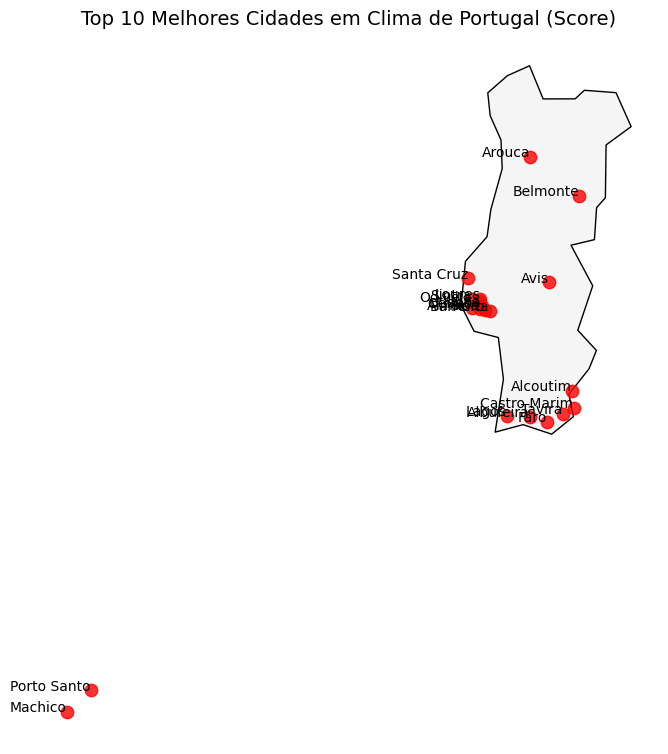

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Caminho para o arquivo shapefile (.shp)
shapefile_path = '..\\..\\Bases\\Geocoding\\files\\Admin 0 – Countries\\ne_110m_admin_0_countries.shp'

# Carrega o shapefile
portugal = gpd.read_file(shapefile_path)
portugal = portugal[portugal['NAME'] == 'Portugal']  # Coluna pode ser 'NAME' ou 'name' dependendo do shape

# Cria GeoDataFrame das cidades
gdf = gpd.GeoDataFrame(
    top10,
    geometry=gpd.points_from_xy(top10['longitude'], top10['latitude']),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(8,10))
portugal.plot(ax=ax, color='whitesmoke', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=80, alpha=0.8)

# Adiciona o nome das cidades
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['location']):
    ax.text(x, y, label, fontsize=10, ha='right')

plt.title('Top 10 Melhores Cidades em Clima de Portugal (Score)', fontsize=14)
plt.axis('off')
plt.show()


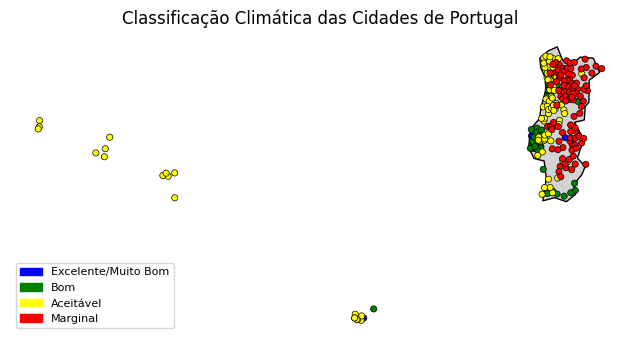

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Dicionário de cores
cores = {
    'Excelente': 'blue',
    'Muito Bom': 'blue',
    'Bom': 'green',
    'Aceitável': 'yellow',
    'Marginal': 'red'
}
ranking_geo['cor'] = ranking_geo['classificacao'].map(cores)

# Converte para GeoDataFrame
gdf = gpd.GeoDataFrame(
    ranking_geo, geometry=gpd.points_from_xy(ranking_geo.longitude, ranking_geo.latitude), crs="EPSG:4326"
)

# Carrega o shapefile de Portugal (pode ajustar o caminho e a coluna se necessário)
shapefile_path = '..\\..\\Bases\\Geocoding\\files\\Admin 0 – Countries\\ne_110m_admin_0_countries.shp'
portugal = gpd.read_file(shapefile_path)
portugal = portugal[portugal['NAME'] == 'Portugal']

# Plota o mapa
fig, ax = plt.subplots(figsize=(8, 10))
portugal.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color=gdf['cor'], markersize=20, marker='o', edgecolor='black', linewidth=0.5)

# Adiciona legenda
import matplotlib.patches as mpatches
patches = [
    mpatches.Patch(color='blue', label='Excelente/Muito Bom'),
    mpatches.Patch(color='green', label='Bom'),
    mpatches.Patch(color='yellow', label='Aceitável'),
    mpatches.Patch(color='red', label='Marginal')
]
plt.legend(handles=patches, loc='lower left', fontsize=8)

plt.title('Classificação Climática das Cidades de Portugal')
plt.axis('off')
plt.show()

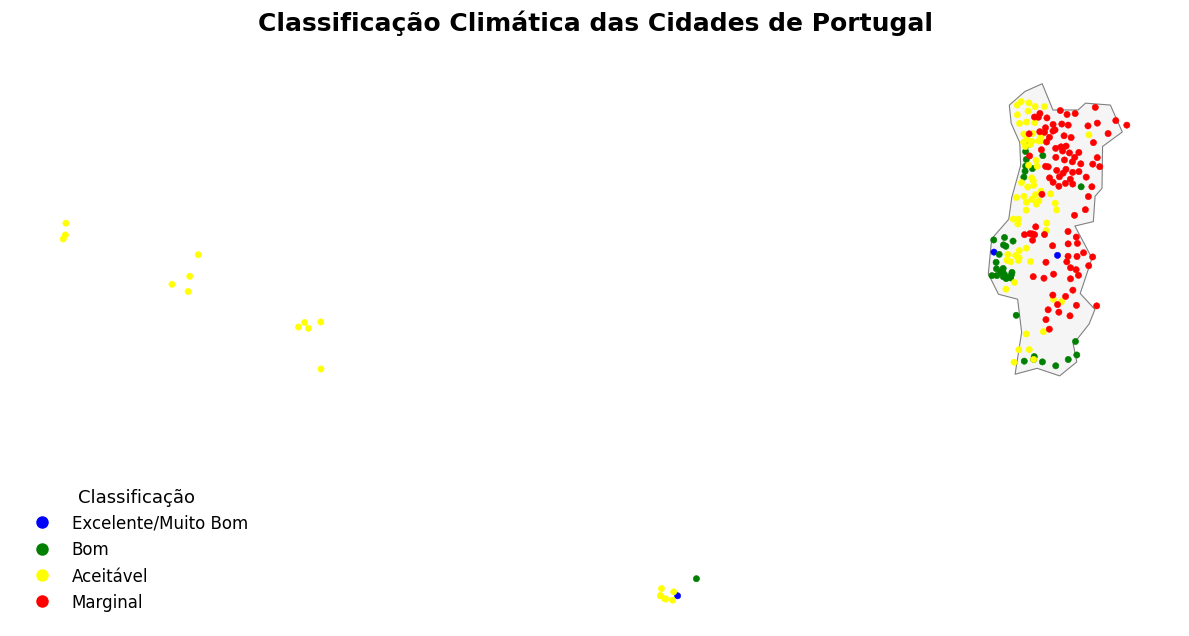

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 16))

portugal.plot(ax=ax, color='whitesmoke', edgecolor='gray', linewidth=0.8)
gdf.plot(ax=ax, color=gdf['cor'], markersize=20, marker='o', linewidth=0.4)

plt.axis('off')
plt.title('Classificação Climática das Cidades de Portugal', fontsize=18, weight='bold', pad=20)

# Legenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Excelente/Muito Bom', markerfacecolor=cores['Excelente'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Bom', markerfacecolor=cores['Bom'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Aceitável', markerfacecolor=cores['Aceitável'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Marginal', markerfacecolor=cores['Marginal'], markersize=10),
]
ax.legend(handles=legend_elements, title="Classificação", loc='lower left', frameon=False, fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

In [132]:
!pip install dataframe_image

     ---------------------------------------- 6.7/6.7 MB 6.1 MB/s eta 0:00:00
     -------------------------------------- 258.5/258.5 kB 8.0 MB/s eta 0:00:00
     -------------------------------------- 452.3/452.3 kB 5.6 MB/s eta 0:00:00
     -------------------------------------- 53.4/53.4 kB 918.5 kB/s eta 0:00:00
     --------------------------------------- 35.4/35.4 MB 16.4 MB/s eta 0:00:00
     ---------------------------------------- 44.0/44.0 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 45.9/45.9 kB 151.9 kB/s eta 0:00:00
     ---------------------------------------- 41.5/41.5 kB 1.0 MB/s eta 0:00:00
     -------------------------------------- 86.7/86.7 kB 181.2 kB/s eta 0:00:00
     ------------------------------------- 163.4/163.4 kB 10.2 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 2.2 MB/s eta 0:00:00
     -------------------------------------- 297.0/297.0 kB 9.3 MB/s eta 0:00:00


In [ ]:
# Define a ordem desejada dos grupos
ordem_grupos = ['Muito Bom', 'Bom', 'Aceitável', 'Marginal']

# Corrige as colunas numéricas caso estejam com vírgula
for col in ['score', 'maxtempC', 'mintempC']:
    ranking_geo[col] = (
        ranking_geo[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

for col in ['calor_extremo', 'frio_extremo', 'chuva_extrema', 'neve', 'uv_extremo']:
    ranking_geo[col] = (
        ranking_geo[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
        .astype(int)
    )

# Cria coluna de total de eventos extremos
ranking_geo['eventos_extremos'] = (
    ranking_geo['calor_extremo'] +
    ranking_geo['frio_extremo'] +
    ranking_geo['chuva_extrema'] +
    ranking_geo['neve'
    ranking_geo['uv_extremo']
)

# Cria a lista ordenada
texto = '🏆 Ranking de Cidades por Categoria Climática 🏆\n'
for cat in ordem_grupos:
    grupo = ranking_geo[ranking_geo['classificacao'] == cat].sort_values('score', ascending=False)
    if not grupo.empty:
        texto += f'\n🔵 {cat}:\n'
        for _, row in grupo.iterrows():
            texto += (
                f"   - {row['location']}: {row['score']:.1f} pontos | "
                f"Extremos: {row['eventos_extremos']} | "
                f"Máx: {row['maxtempC']:.1f}°C | "
                f"Mín: {row['mintempC']:.1f}°C\n"
            )

print(texto)


🏆 Ranking de Cidades por Categoria Climática 🏆

🔵 Muito Bom:
   - Machico: 71.7 pontos | Extremos: 3 | Máx: 21.0°C | Mín: 16.9°C
   - Santa Cruz: 71.7 pontos | Extremos: 3 | Máx: 21.0°C | Mín: 16.9°C
   - Avis: 71.3 pontos | Extremos: 1 | Máx: 26.6°C | Mín: 13.4°C

🔵 Bom:
   - Porto Santo: 69.4 pontos | Extremos: 1 | Máx: 20.1°C | Mín: 19.2°C
   - Faro: 66.3 pontos | Extremos: 2 | Máx: 21.1°C | Mín: 15.7°C
   - Lagos: 66.1 pontos | Extremos: 1 | Máx: 20.7°C | Mín: 14.7°C
   - Belmonte: 66.1 pontos | Extremos: 2 | Máx: 21.2°C | Mín: 15.6°C
   - Oeiras: 64.5 pontos | Extremos: 5 | Máx: 20.4°C | Mín: 14.4°C
   - Almada: 63.7 pontos | Extremos: 3 | Máx: 21.6°C | Mín: 13.9°C
   - Barreiro: 63.7 pontos | Extremos: 3 | Máx: 21.6°C | Mín: 13.9°C
   - Loures: 63.6 pontos | Extremos: 5 | Máx: 21.2°C | Mín: 14.0°C
   - Odivelas: 63.6 pontos | Extremos: 5 | Máx: 21.2°C | Mín: 14.0°C
   - Lisboa: 63.6 pontos | Extremos: 5 | Máx: 21.2°C | Mín: 14.0°C
   - Albufeira: 63.5 pontos | Extremos: 5 | Máx: 